| 평가문항 | 상세기준 |
| --- | --- |
| 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가? | 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가? |
| 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가? | SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다. |
| 3. SentencePiece의 성능을 다각도로 비교분석하였는가? | SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다. |

# STEP0. 라이브러리 버전을 확인

In [1]:
import pandas as pd
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Step 1. SentencePiece 설치하기
SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

- [google/sentencepiece](https://github.com/google/sentencepiece)     

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

- $ pip install sentencepiece

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f59a01bffa0>)

In [3]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
print('데이터 개수 :', len(naver_df))

데이터 개수 : 200000


## 결측치, 중복 확인 및 제거

In [5]:
origin_len = len(naver_df)

In [6]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [7]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [8]:
print('결측치 제거 후 데이터 개수 :', len(naver_df))  

결측치 제거 후 데이터 개수 : 199992


In [9]:
cleaned_corpus = naver_df.drop_duplicates(['document'])   

In [10]:
print('중복 제거 후 데이터 개수 :', len(cleaned_corpus))

중복 제거 후 데이터 개수 : 194543


In [11]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [12]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 분석 및 전처리

In [13]:
naver_review = cleaned_corpus['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_7854/1743548021.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


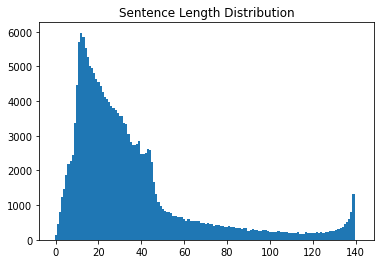

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최장 길이 142에 가까운 데이터들이 생각 보다 많다.      
어떤 문장인지 확인해보자

In [15]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return 

check_sentence_with_length(naver_review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

- sentence_length[문장 길이] = 갯수 
- idx = 문장길이 , _sum = 해당 문장 길이인 문장의 개수 


In [16]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135 초과하는 문장 길이를 추출합니다.
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


**문장 길이 10이하의 문장을 확인**

In [17]:
check_sentence_with_length(naver_review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [18]:
check_sentence_with_length(naver_review, 2)

쵝오
최고
좋아
흐흐
개쩜
굳뜨
좋다
섬뜩
♥♥
ㅎㅎ
대박
잼슴
굳굳
10
ㄹㄹ
윤하
유쾌
긋~
잼남
박수
수작
굳!
졸잼
꿈.
쏘우
굿!
명작
대작
잼네
맞아
ㅇㅇ
완벽
오우
굿굿
ㅠㅠ
굿잡
와우
..
좋네
無言
미투
gg
ㅋㅋ
후훗
걸작
잼잼
나두
예뻐
^^
만점
웃김
오호
설리
좋너
의읭
감동
원작
구ㄷ
하하
좋음
조앙
멋져
매력
개박
조음
추천
탁월
조아
쩔어
감독
가슴
재밋
잼씀
진리
붉다
눈물
오오
9점
zz
잼따
1등
짱임
홧팅
쳐봐
신고
짱♥
ㅡㅡ
역시
뻥임
섹시
명품
우정
짱~
동참
짱짱
야한
ㅊㅊ
굿~
대단
반담
만족


In [19]:
check_sentence_with_length(naver_review, 3)

재밌다
가연세
재밋다
야마켄
재밌음
좋아요
괜찮네
화려함
좋은데
짱~~
재밋음
굿..
킹왕짱
재밌어
까까~
진짜다
재밌당
명작.
잼있다
재미다
재미짐
몽정기
최고다
각키♥
수작.
참재미
채고야
베리굳
김은미
굿!!
갑이다
구여움
좋구나
행~복
10점
ㅎ최고
재밌군
멋지당
최고임
똥파리
잘봤음
...
조아요
하하하
굿굿굿
훌륭함
재미닷
재밋당
좋ㅎ음
쩐다;
ㅋㅋㅋ
개코미
화이팅
잼네요
귀여움
으리!
좋다.
팬심♥
볼만함
감동적
감동임
감동~
패닝짱
목두기
괜찬네
재미씀
좋네요
참좋다
동감.
ㅋ재미
재밋쪼
한석규
재밌긔
웃긴데
감동!
ㅎㄷㄷ
아프다
대단함
걸작.
람보3
명작!
나의꿈
잼겟따
신선함
갱호~
재밌네
대박!
^-^
연출력
오ㅓㅏ
재및음
굿 ㅋ
오호호
괜찮음
드라마
zzz
최고!
감동함
짱짱맨
구구굿
멋있다


In [20]:
check_sentence_with_length(naver_review, 9)

이스트우드 최고작
썩 괜찮았던 영화
거의 10점 짜리
흥미로운 전기영화
치즈루 귀여워 ㅠ
ㅋㅋ올만에 웃었다
꽤 재밋네요!^^
좋았다 정말...
신비롭고 아름답다
총의 포스가...
존경받을만 하다.
다시 올리기 ㄱㄱ
정말 최고의 영화
김수로 너무 좋아
그것 엄청재밋는디
최고의 드라마..
첫사랑이 생각난다
최고내요 색달라요
나만 재밋게 봤나
재미있어요.ㅋㅋㅋ
이이 러브 나루토
최고의드라마~~ㅋ
개봉은 17일인데
정말 재밋다 쿨럭
잼나요......
개.쩌.는.영.화
역시 아메리칸파이
짱재밌음 꼭 보셈
감동 ㅠㅠ....
진짜재밋어요ㅋㅋㅋ
보기 좋았던 영화
다시 보고 싶다.
정려원 최고다,,
넌GAMEOVER
미실, 비담 최고
미친 사랑 이야기
너무재밌어요 강추
내 인생의 작품!
수고많으셨습니다.
송승헌걍짜응...
이런영화좋다...
나의 영원한 로망
눈이호강하네여ㅎㅎ
전 재밌는데용..
3보다 재밌는데?
충주성심 파이팅!
에단때문에 10점
재밌어요재밌어ㅜㅜ
울면서 봤어영..
한마디로 굳!!!
진짜 재미있어요.
봉묨ㅂ모몽모뭄ㅇㄷ
다들 죽지 말아라
1편만큼 재밌다.
잘만든 드라마 ㅎ
경탁이 최고~!!
그냥 말이필요없다
아빠! 힘내세요~
아주 웃겼습니다.
조미 넘 이뻐 ㅋ
그냥 평점 오르기
이보희의 아름다움
이건흥행해야된다.
액션신이너무좋았다
짱짱 진짜멋잇어요
감동적인 전기영화
음... 재밌었다
부시는 나쁜 쉐리
brilliant
블랙코미디의 진수
이해와 배려사이.
당시 최고의 영화
..하하,....
!!!대박 ㅇㅅㅇ
송강호 개쩌네ㅋㅋ
재밌고 감동있어요
나카야마 시노부♥
진짜 짱인거 같아
짱 재밌어요 ㅋㅋ
느낌 괜찮은 영화
난 재밌었음 :D
정말 순수한 영화
무성영화, 불꽃,
감동, 스릴, 굿
올해 최고의 영화
따뜻한 애니메이션
정말 따뜻한 영화
박예진 예뻐 예뻐
예술영화의 완성작
그냥눈물이나왔다.
희망은 좋은것이다
멕라이언 짱귀여워
난 무서웠음...
완전 재미있음 ~
엑스파일메니아라면
존나 웃겨 ㅋㅋㅋ
..정말 쩔어요.
좀비영화중 왕중왕
지금봐도 대단ㅎㅎ
정말 이쁜 드라마


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_7854/4241797388.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


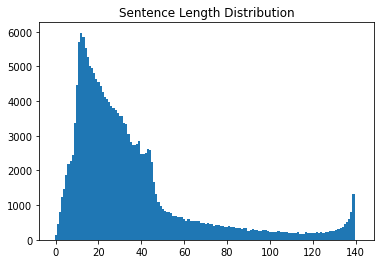

In [21]:
min_len = 999
max_len = 0
sum_len = 0

# cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(naver_review)) 

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 최적의 max_len을 찾는 함수

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [23]:
below_threshold_len(36, naver_review)  # 평균
below_threshold_len(140, naver_review)  # 최장 
below_threshold_len(70, naver_review)  # 중앙값
below_threshold_len(50, naver_review)  
below_threshold_len(60, naver_review)  

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.05640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962


**"문장길이 <= 100"** 으로 처리

/tmp/ipykernel_7854/1241865566.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


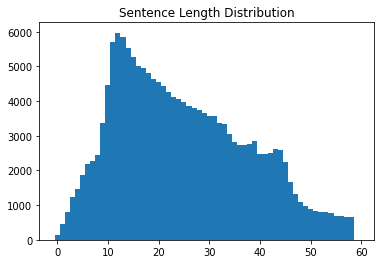

In [24]:
max_len = 60   
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

# 1. 내가 짰지만 비효율적인 코드 
filtered_corpus = [] 
filtered_label = []  
for row, label in zip(naver_df['document'], naver_df['label']):    
    if (len(row) < max_len):     
        filtered_corpus.append(row)  
        filtered_label.append(label)   
        
# 2. 같이 공부하는 @수희님이 알려주신 코드 
# 데이터프레임 조건부 슬라이싱 
# str.len() 두 함수에 대해 알 수 있었다. 
train_data = cleaned_corpus[cleaned_corpus['document'].str.len() < max_len]   



# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [25]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,    0])

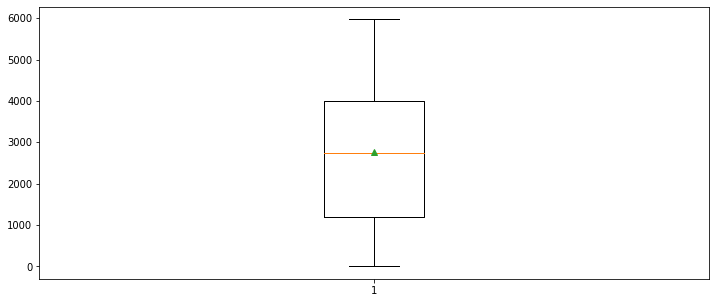

In [26]:
plt.figure(figsize=(12,5))
plt.boxplot([sentence_length], showmeans=True)
plt.show()

In [27]:
print('전처리 전 데이터 개수 :', len(naver_df))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(naver_df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 166401
전처리 후 남은 데이터 양(%) 83.20382815312612


# Step 2. SentencePiece 모델 학습
앞서 배운 tokenize() 함수를 기억하나요? 다시 한번 상기시켜드릴게요!
```
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
``` 
위와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고  
tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다.

In [28]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

#### 왜 학습이 안될까?

In [29]:
# vocab size=8000, model_type=unigram
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
# )

# 
# vocab size=16000, model_type=unigram
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=kor_spm_uingram_4k --vocab_size={}'.format(temp_file, vocab_size//2)    
# )

# # vocab size=8000, model_type=bpe
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
# )

# vocab size = 16000, model_type=bpe
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size*2)    
#)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.


In [30]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 375162 Mar 18 02:51 korean_spm.model
-rw-r--r-- 1 root root 144497 Mar 18 02:51 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [31]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_unigram_4k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_bpe_16k*

-rw-r--r-- 1 root root 375096 Mar 22 08:23 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144435 Mar 22 08:23 kor_spm_unigram_8k.vocab
ls: cannot access 'kor_spm_unigram_4k*': No such file or directory
-rw-r--r-- 1 root root 370378 Mar 22 08:26 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root 115580 Mar 22 08:26 kor_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 523017 Mar 22 03:09 kor_spm_bpe_16k.model
-rw-r--r-- 1 root root 258215 Mar 22 03:09 kor_spm_bpe_16k.vocab


In [32]:
vocab_list = pd.read_csv('kor_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.27463
4,.,-3.47852
5,..,-4.24637
6,▁영화,-4.42651
7,이,-4.44480
8,...,-4.48456
9,가,-4.71341


In [33]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 8000


,0,1
2998,▁안타깝다,-9.79105
5249,▁꼭보세요,-10.43360
4857,다는게,-10.33320
736,▁좋아하는,-8.40470
1935,났다,-9.34159
3144,▁나왔다,-9.84668
4926,부터가,-10.35240
3304,딸,-9.89616
5467,▁삶이,-10.48720
6556,▁개그맨,-10.80980


## SentencePiece 성능 비교평가
- vocab size = 8k, 16k
- model type = unigram, bpe
- kor_spm_unigram_8k
- kor_spm_unigram_16k
- kor_spm_bpe_8k
- kor_spm_bpe_16k

In [34]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [35]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

# # unigram은 오류가 나서 학습이 되지 않았다. 
# print('kor_spm_unigram_4k')
# test_performance(model='kor_spm_unigram_4k.model')

print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

print('kor_spm_bpe_16k')
test_performance(model='kor_spm_bpe_16k.model')

kor_spm_unigram_8k
[1653, 9, 464, 16, 1383, 9, 158, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_8k
[6043, 990, 6533, 6257, 1506, 6252, 6360, 6246, 6244]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_16k
[9096, 12780, 1506, 14252, 11430, 14244]
['▁아버지가', '방에', '들어', '가', '신다', '.']
아버지가방에들어가신다.


# Step 3. Tokenizer 함수 작성
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

> 1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.          
> 2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 >{<idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.         
> 3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [36]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [37]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
# s.Load('kor_spm_bpe_16k.model')  # lstm 학습시 오류

s.Load('kor_spm_unigram_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'kor_spm_unigram_8k')           
print(tensor)
# print(word_index)
# print(index_word)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  517 3252
    14 1097 2572    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1592 2168  228  544    9
   280 7921  756    8]]


# Step 4. LSTM으로 감정분석 모델 학습
SentencePiece 토크나이저가 적용된 모델을 학습 후 수렴하는 것을 확인합니다.
SentencePiece 토크나이저 성능 평가

In [38]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'kor_spm_unigram_8k')

In [39]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [40]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [42]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

bpe, vocab size 16k로 설정한 모델은 에러가 발생

In [43]:
# model_LSTM.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs=10
# batch_size=1000

# history_LSTM = model_LSTM.fit(x_train,
#                     y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     verbose=1)

In [44]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 207s 123ms/step - loss: 0.4040 - accuracy: 0.8142 - val_loss: 0.3511 - val_accuracy: 0.8455
Epoch 2/20
1664/1664 [==============================] - 204s 123ms/step - loss: 0.3239 - accuracy: 0.8592 - val_loss: 0.3361 - val_accuracy: 0.8521
Epoch 3/20
1664/1664 [==============================] - 205s 123ms/step - loss: 0.2890 - accuracy: 0.8742 - val_loss: 0.3364 - val_accuracy: 0.8547
Epoch 4/20
1664/1664 [==============================] - 205s 123ms/step - loss: 0.2572 - accuracy: 0.8889 - val_loss: 0.3431 - val_accuracy: 0.8513
Epoch 5/20
1664/1664 [==============================] - 204s 123ms/step - loss: 0.2293 - accuracy: 0.9028 - val_loss: 0.3558 - val_accuracy: 0.8500
Epoch 6/20
1664/1664 [==============================] - 203s 122ms/step - loss: 0.2028 - accuracy: 0.9160 - val_loss: 0.3885 - val_accuracy: 0.8479
Epoch 00006: early stopping


In [45]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

832/832 - 22s - loss: 0.3894 - accuracy: 0.8490
[0.3894230127334595, 0.8489708304405212]


# Step 5. 모델 성능 비교 평가
**비교 대상**
- LSTM의 input x_data를 토크나이징한 SentencePiece 모델
- LSTM모델의 Word_vector_dimension

In [46]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)
    
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim,
                                        ))

    model_LSTM.add(keras.layers.LSTM(128))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=10
    batch_size=64
    
#     es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    history_LSTM = model_LSTM.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val),
                        callbacks=[es],
                        verbose=1)
    
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    print(results)
    
    return history_LSTM

In [47]:
history_unigram_8k_dim_8 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=8)
history_unigram_8k_dim_64 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 188s 112ms/step - loss: 0.4257 - accuracy: 0.8023 - val_loss: 0.3646 - val_accuracy: 0.8417
Epoch 2/10
1664/1664 [==============================] - 188s 113ms/step - loss: 0.3327 - accuracy: 0.8572 - val_loss: 0.3536 - val_accuracy: 0.8463
Epoch 3/10
1664/1664 [==============================] - 187s 112ms/step - loss: 0.

In [48]:
history_bpe_8k_dim_8 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=8)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 189s 113ms/step - loss: 0.4218 - accuracy: 0.8042 - val_loss: 0.3730 - val_accuracy: 0.8371
Epoch 2/10
1664/1664 [==============================] - 188s 113ms/step - loss: 0.3344 - accuracy: 0.8564 - val_loss: 0.3562 - val_accuracy: 0.8439
Epoch 3/10
1664/1664 [==============================] - 187s 112ms/step - loss: 0.

In [49]:
history_bpe_8k_dim_8 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=8)
history_bpe_16k_dim_64 = performance_test_spm('kor_spm_bpe_8k', vocab_size, word_vector_dim=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 197s 117ms/step - loss: 0.4117 - accuracy: 0.8084 - val_loss: 0.3685 - val_accuracy: 0.8394
Epoch 2/10
1664/1664 [==============================] - 195s 117ms/step - loss: 0.3335 - accuracy: 0.8559 - val_loss: 0.3521 - val_accuracy: 0.8471
Epoch 3/10
1664/1664 [==============================] - 193s 116ms/step - loss: 0.

In [50]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

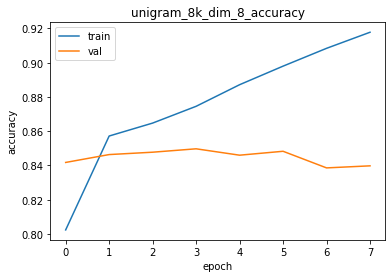

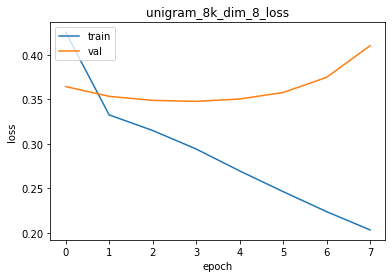

In [51]:
visualize_train(history_unigram_8k_dim_8, param='unigram_8k_dim_8')

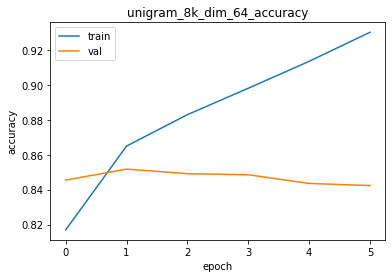

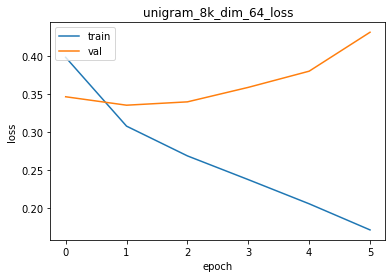

In [52]:
visualize_train(history_unigram_8k_dim_64, param='unigram_8k_dim_64')

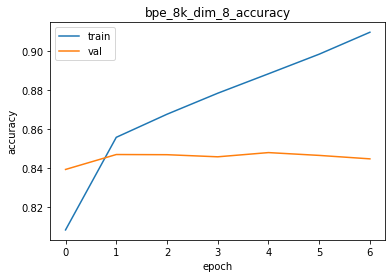

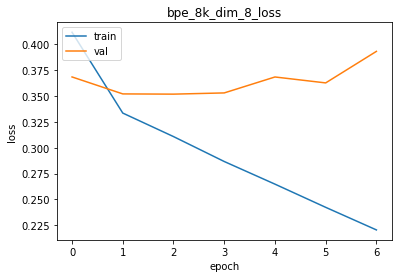

In [53]:
visualize_train(history_bpe_8k_dim_8, param='bpe_8k_dim_8')

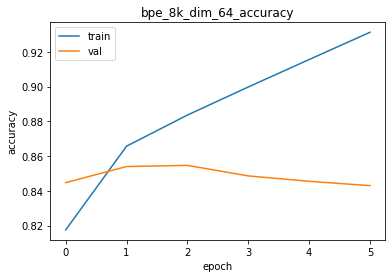

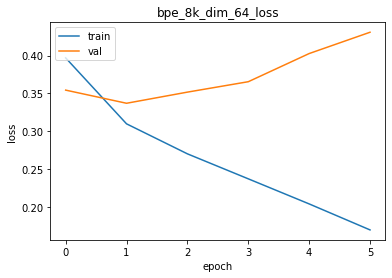

In [54]:
visualize_train(history_bpe_16k_dim_64, param='bpe_8k_dim_64')

# 회고 
- NLP에서는 전처리 하는 부분이 가장 어려운거 같다. 해당 과제 이전에 여러가지 전처리방법, 토크나이징 등등 많이 공부하고 이번에 또 다시 공부해서 많은 도움이 됐던 과제였따.

- 자연어 모델에서 제대로 학습이 이루어지지 않는 모델이 있었다.((bpe, vocab size 16k)

- 토큰화가 제대로 작동되지 않는 모델도 있었다. (unigram, vocab size 16k) 

- LSTM모델의 파라미터 단어 벡터 차원을 조정해서 비교했다.

# 느낀점
- 전처리 과정이 너무 어렵다. 그렇지만 하면서도 재밌고 많은 시간과 노력이 필요하다는 것을 깨달았다.